In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import joblib


In [4]:
transactions = pd.read_csv("ecommerce_transactions.csv")
customers = pd.read_csv("E-commerce Customer Behavior - Sheet1.csv")
print("Transactions Shape:", transactions.shape)
print("Customers Shape:", customers.shape)
transactions.head(), customers.head()



Transactions Shape: (50000, 8)
Customers Shape: (350, 11)


(   Transaction_ID        User_Name  Age  Country Product_Category  \
 0               1         Ava Hall   63   Mexico         Clothing   
 1               2      Sophia Hall   59    India           Beauty   
 2               3  Elijah Thompson   26   France            Books   
 3               4     Elijah White   43   Mexico           Sports   
 4               5       Ava Harris   48  Germany           Beauty   
 
    Purchase_Amount Payment_Method Transaction_Date  
 0           780.69     Debit Card       2023-04-14  
 1           738.56         PayPal       2023-07-30  
 2           178.34    Credit Card       2023-09-17  
 3           401.09            UPI       2023-06-21  
 4           594.83    Net Banking       2024-10-29  ,
    Customer ID  Gender  Age           City Membership Type  Total Spend  \
 0          101  Female   29       New York            Gold      1120.20   
 1          102    Male   34    Los Angeles          Silver       780.50   
 2          103  Female  

In [5]:
transactions['Transaction_Date'] = pd.to_datetime(transactions['Transaction_Date'])

agg_trans = transactions.groupby("User_Name").agg(
    total_purchase_amount=("Purchase_Amount", "sum"),
    frequency=("Transaction_ID", "count"),
    last_purchase_date=("Transaction_Date", "max"),
    product_diversity=("Product_Category", "nunique"),
    avg_order_value=("Purchase_Amount", "mean")
).reset_index()

latest_date = transactions['Transaction_Date'].max()
agg_trans['recency_days'] = (latest_date - agg_trans['last_purchase_date']).dt.days

agg_trans.head()


,User_Name,total_purchase_amount,frequency,last_purchase_date,product_diversity,avg_order_value,recency_days
0,Ava Allen,247865.13,494,2025-03-08,8,501.751275,0
1,Ava Anderson,246801.09,491,2025-03-08,8,502.649878,0
2,Ava Clark,273776.79,517,2025-03-07,8,529.548917,1
3,Ava Hall,268756.73,517,2025-03-03,8,519.838936,5
4,Ava Harris,266846.08,520,2025-03-05,8,513.165538,3


In [6]:
customer_df = customers.copy()

le = LabelEncoder()
customer_df['Membership_Code'] = le.fit_transform(customer_df['Membership Type'])
customer_df['Discount_Code'] = customer_df['Discount Applied'].astype(int)
customer_df['Satisfaction_Code'] = le.fit_transform(customer_df['Satisfaction Level'])

customer_features = customer_df[[
    'Customer ID', 'Total Spend', 'Items Purchased',
    'Average Rating', 'Discount_Code', 'Days Since Last Purchase',
    'Satisfaction_Code', 'Membership_Code'
]]

customer_features.head()


,Customer ID,Total Spend,Items Purchased,Average Rating,Discount_Code,Days Since Last Purchase,Satisfaction_Code,Membership_Code
0,101,1120.20,14,4.6,1,25,1,1
1,102,780.50,11,4.1,0,18,0,2
2,103,510.75,9,3.4,1,42,2,0
3,104,1480.30,19,4.7,0,12,1,1
4,105,720.40,13,4.0,1,55,2,2


In [7]:
final_df = pd.merge(
    agg_trans,
    customer_features,
    left_index=True,
    right_index=True,
    how="left"
)

final_df.fillna(0, inplace=True)
final_df.head()


,User_Name,total_purchase_amount,frequency,last_purchase_date,product_diversity,avg_order_value,recency_days,Customer ID,Total Spend,Items Purchased,Average Rating,Discount_Code,Days Since Last Purchase,Satisfaction_Code,Membership_Code
0,Ava Allen,247865.13,494,2025-03-08,8,501.751275,0,101,1120.20,14,4.6,1,25,1,1
1,Ava Anderson,246801.09,491,2025-03-08,8,502.649878,0,102,780.50,11,4.1,0,18,0,2
2,Ava Clark,273776.79,517,2025-03-07,8,529.548917,1,103,510.75,9,3.4,1,42,2,0
3,Ava Hall,268756.73,517,2025-03-03,8,519.838936,5,104,1480.30,19,4.7,0,12,1,1
4,Ava Harris,266846.08,520,2025-03-05,8,513.165538,3,105,720.40,13,4.0,1,55,2,2


In [8]:
y = final_df['Total Spend']
X = final_df[[
    'frequency', 'recency_days', 'avg_order_value', 'product_diversity',
    'Items Purchased', 'Average Rating', 'Discount_Code',
    'Days Since Last Purchase', 'Satisfaction_Code', 'Membership_Code'
]]


In [9]:
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X, y)
joblib.dump(model, "ltv_model.pkl")
print("✅ Model trained & saved successfully!")


✅ Model trained & saved successfully!


In [10]:
final_df['Predicted_LTV'] = model.predict(X)
final_df.head()


,User_Name,total_purchase_amount,frequency,last_purchase_date,product_diversity,avg_order_value,recency_days,Customer ID,Total Spend,Items Purchased,Average Rating,Discount_Code,Days Since Last Purchase,Satisfaction_Code,Membership_Code,Predicted_LTV
0,Ava Allen,247865.13,494,2025-03-08,8,501.751275,0,101,1120.20,14,4.6,1,25,1,1,1128.810167
1,Ava Anderson,246801.09,491,2025-03-08,8,502.649878,0,102,780.50,11,4.1,0,18,0,2,786.741333
2,Ava Clark,273776.79,517,2025-03-07,8,529.548917,1,103,510.75,9,3.4,1,42,2,0,511.613000
3,Ava Hall,268756.73,517,2025-03-03,8,519.838936,5,104,1480.30,19,4.7,0,12,1,1,1436.395000
4,Ava Harris,266846.08,520,2025-03-05,8,513.165538,3,105,720.40,13,4.0,1,55,2,2,715.038667


In [11]:
final_df['Segment'] = pd.qcut(final_df['Predicted_LTV'], 3, labels=['Low', 'Medium', 'High'])
final_df[['User_Name', 'Predicted_LTV', 'Segment']].head(15)


,User_Name,Predicted_LTV,Segment
0,Ava Allen,1128.810167,High
1,Ava Anderson,786.741333,Medium
2,Ava Clark,511.613000,Low
3,Ava Hall,1436.395000,High
4,Ava Harris,715.038667,Medium
5,Ava Lewis,438.510667,Low
6,Ava Rodriguez,1148.329667,High
7,Ava Thompson,809.045167,Medium
8,Ava Walker,492.226000,Low
9,Ava White,1504.824333,High


In [12]:
mae = mean_absolute_error(y, final_df['Predicted_LTV'])
rmse = np.sqrt(mean_squared_error(y, final_df['Predicted_LTV']))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 4.17
Root Mean Squared Error (RMSE): 9.40


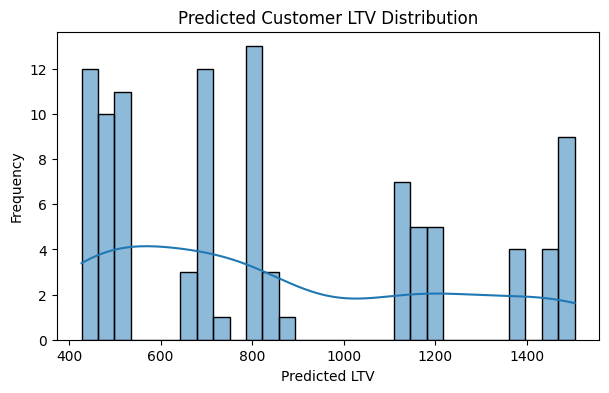

C:\Users\Vinodini\AppData\Local\Temp\ipykernel_2656\1789887174.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=final_df['Segment'], palette='Set2')


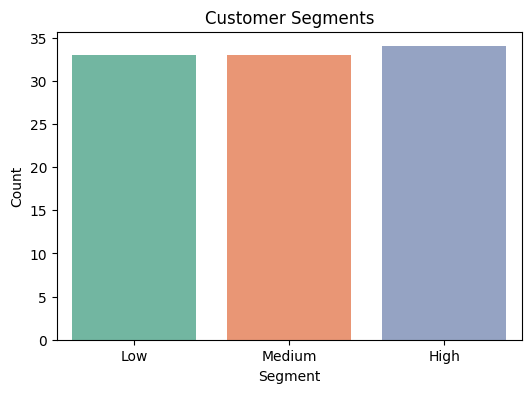

✅ Predictions saved successfully as LTV_predictions.csv


In [13]:
# LTV Distribution
plt.figure(figsize=(7,4))
sns.histplot(final_df['Predicted_LTV'], bins=30, kde=True)
plt.title("Predicted Customer LTV Distribution")
plt.xlabel("Predicted LTV")
plt.ylabel("Frequency")
plt.show()

# Customer Segments
plt.figure(figsize=(6,4))
sns.countplot(x=final_df['Segment'], palette='Set2')
plt.title("Customer Segments")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.show()

# Export predictions
final_df.to_csv("LTV_predictions.csv", index=False)
print("✅ Predictions saved successfully as LTV_predictions.csv")
